<a href="https://colab.research.google.com/github/dev-SR/Deep-Learning/blob/main/02-FFN-pytorch-workflow/ffn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch Feed Forward Networks Workflow

- Building Multi perceptron neural network from scratch to pytorch modular

In [28]:
"""
cd .\02-FFN-pytorch-workflow\
jupyter nbconvert --to markdown ffn.ipynb --output README.md
"""
import torch
import torch.nn.functional as Fn
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

## Generate Dataset

In [30]:
from sklearn.datasets import make_blobs
data,labels = make_blobs(n_samples=1000,centers=4,n_features=2,random_state=0)
print(data.shape,labels.shape)

(1000, 2) (1000,)


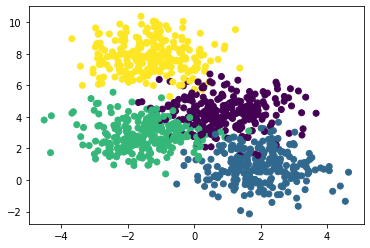

In [31]:
# mymap = matplotlib.colors.LinearSegmentedColormap.from_list("",['red','yellow','green','blue'])
plt.scatter(data[:,0],data[:,1],c=labels)#,cmap=mymap)

In [32]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(data,labels,test_size=0.2,random_state=0)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(800, 2) (200, 2) (800,) (200,)


In [33]:
X_train,X_test,y_train,y_test = map(torch.tensor,(X_train,X_test,y_train,y_test))
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

torch.Size([800, 2]) torch.Size([200, 2]) torch.Size([800]) torch.Size([200])


## Using torch tensor and autograd

<p align="center">
<img src="https://raw.githubusercontent.com/dev-SR/Deep-Learning/main/02-FFN-pytorch-workflow/img/ShapeCalculation.png" alt="ShapeCalculation.png" width="900px">
</p>

In [34]:
torch.manual_seed(0)
W1 = torch.randn(10,2) / math.sqrt(2) # Shape-> (L_out,L_in)
W1.requires_grad_()
b1 = torch.zeros(10,requires_grad=True) 

W2 = torch.randn(4,10) / math.sqrt(2) # Shape-> (L_out,L_in)
W2.requires_grad_()
b2 = torch.zeros(4,requires_grad=True)

print(W1.shape,W2.shape)

torch.Size([10, 2]) torch.Size([4, 10])


In [35]:
def model(X):
    a1 = torch.matmul(X,W1.T) + b1 # (N,2) x (2,10)^T => (N,10)
    # print(a1.shape)
    h1 = a1.sigmoid() # (N,10)
    # print(h1.shape)
    a2 = torch.matmul(h1,W2.T) + b2 # (N,10) x (10,4)^T => (N,4)
    # print(a2.shape)
    h2 = a2.softmax(dim=1) # (N,4)
    # print(h2.shape)
    return h2


In [36]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_hat, y):
    pred = torch.argmax(y_hat,dim=1)
    return (pred==y).float().mean()

Loss before training : 1.4318073987960815
Loss after training : 0.8514120578765869


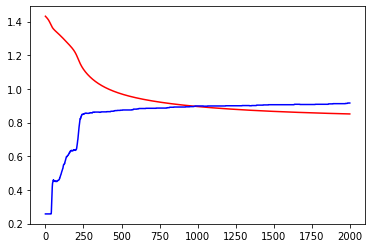

In [37]:
learning_rate = 0.2
epochs = 2000

X_train = X_train.float()
Y_train = y_train.long()

loss_err = []
acc_err = []

for epoch in range(epochs):
    y_hat = model(X_train)
    loss = Fn.cross_entropy(y_hat,Y_train)
    loss_err.append(loss.item())
    acc_err.append(accuracy_fn(y_hat,y_train))
    loss.backward()    
    
    with torch.no_grad():
        W1 -= W1.grad * learning_rate
        b1 -= b1.grad * learning_rate
        W2 -= W2.grad * learning_rate
        b2 -= b2.grad * learning_rate
        
        W1.grad.zero_()
        b1.grad.zero_()
        W2.grad.zero_()
        b2.grad.zero_()
        
plt.plot(loss_err,'r-')
plt.plot(acc_err,'b-')

print(f"Loss before training : {loss_err[0]}")
print(f"Loss after training : {loss_err[-1]}")

## Using `NN.Parameter`


In [38]:
import torch.nn as nn

In [39]:
# def model(X):
#     a1 = torch.matmul(X,W1.T) + b1 # (N,2) x (2,10)^T => (N,10)
#     # print(a1.shape)
#     h1 = a1.sigmoid() # (N,10)
#     # print(h1.shape)
#     a2 = torch.matmul(h1,W2.T) + b2 # (N,10) x (10,4)^T => (N,4)
#     # print(a2.shape)
#     h2 = a2.softmax(dim=1) # (N,4)
#     # print(h2.shape)
#     return h2
# torch.manual_seed(0)
# W1 = torch.randn(10,2) / math.sqrt(2) # Shape-> (L_out,L_in)
# W1.requires_grad_()
# b1 = torch.zeros(10,requires_grad=True) 

# W2 = torch.randn(4,10) / math.sqrt(2) # Shape-> (L_out,L_in)
# W2.requires_grad_()
# b2 = torch.zeros(4,requires_grad=True)

# print(W1.shape,W2.shape)

In [40]:
class FirstNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(0)
        self.W1 = nn.Parameter(torch.randn(10,2, dtype=torch.float)/math.sqrt(2))
        self.b1 = nn.Parameter(torch.zeros(10))
        self.W2 = nn.Parameter(torch.randn(4,10, dtype=torch.float)/math.sqrt(2))
        self.b2 = nn.Parameter(torch.zeros(4))
        
    def forward(self,X):
        a1= torch.matmul(X,self.W1.T)+b1
        h1 = a1.sigmoid()
        
        a2 = torch.matmul(h1,self.W2.T)+b2
        h2 = a2.softmax(dim=1)
        
        return h2
    
model = FirstNetwork()

Loss before training : 1.3785487413406372
Loss after training : 0.8234154582023621


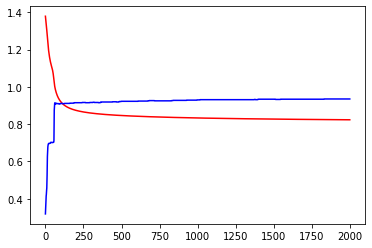

In [41]:
X_train = X_train.float()
Y_train = y_train.long()
def fit(epochs=2000,learning_rate=1):
    loss_err = []
    acc_err = [] 
    for epoch in range(epochs):
        y_hat = model(X_train)
        loss = Fn.cross_entropy(y_hat,y_train.long())
        loss_err.append(loss.item())
        acc_err.append(accuracy_fn(y_hat,y_train))
        
        loss.backward()
        
    
        # with torch.no_grad():
        #     W1 -= W1.grad * learning_rate
        #     b1 -= b1.grad * learning_rate
        #     W2 -= W2.grad * learning_rate
        #     b2 -= b2.grad * learning_rate
            
        #     W1.grad.zero_()
        #     b1.grad.zero_()
        #     W2.grad.zero_()
        #     b2.grad.zero_()  
   
        with torch.no_grad():
            for param in model.parameters():
                if param.grad is not None:
                    param -= learning_rate * param.grad
            model.zero_grad()
    
    plt.plot(loss_err,'r-')
    plt.plot(acc_err,'b-')
    print(f"Loss before training : {loss_err[0]}")
    print(f"Loss after training : {loss_err[-1]}")

fit()

	

## Using `NN.Linear` and `Optim`

In [42]:
import torch.nn as nn
from torch import optim

In [43]:
class NNLinearNetwork_v1(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(0)
        # self.W1 = nn.Parameter(torch.randn(10,2, dtype=torch.float)/math.sqrt(2))
        # self.b1 = nn.Parameter(torch.zeros(10))
        # self.W2 = nn.Parameter(torch.randn(4,10, dtype=torch.float)/math.sqrt(2))
        # self.b2 = nn.Parameter(torch.zeros(4))
        
        self.l1 = nn.Linear(in_features=2,out_features=10)
        self.l2 = nn.Linear(10,4)
        
    def forward(self,X):
        # a1= torch.matmul(X,self.W1.T)+b1
        a1 = self.l1(X)
        h1 = a1.sigmoid()
        
        # a2 = torch.matmul(h1,self.W2.T)+b2
        a2 = self.l2(h1)
        h2 = a2.softmax(dim=1)
        
        return h2
    
model = NNLinearNetwork_v1()

Loss before training : 1.3929063081741333
Loss after training : 0.8134840130805969


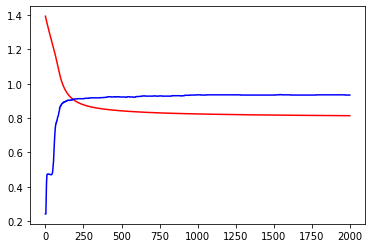

In [44]:
X_train = X_train.float()
Y_train = y_train.long()
def fit(epochs=2000,learning_rate=1):
    loss_err = []
    acc_err = [] 
    opt = optim.SGD(model.parameters(),lr=learning_rate)
    for epoch in range(epochs):
        y_hat = model(X_train)
        loss = Fn.cross_entropy(y_hat,y_train.long())
        loss_err.append(loss.item())
        acc_err.append(accuracy_fn(y_hat,y_train))
        
        loss.backward()
        opt.step()
        opt.zero_grad()
   
        # with torch.no_grad():
        #     for param in model.parameters():
        #         if param.grad is not None:
        #             param -= learning_rate * param.grad
        #     model.zero_grad()
    
    plt.plot(loss_err,'r-')
    plt.plot(acc_err,'b-')
    print(f"Loss before training : {loss_err[0]}")
    print(f"Loss after training : {loss_err[-1]}")

fit()

	

## Using `NN.Sequential`

In [45]:
import torch.nn as nn
from torch import optim

In [46]:
X_train,X_test,y_train,y_test = map(torch.tensor,(X_train,X_test,y_train,y_test))
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

torch.Size([800, 2]) torch.Size([200, 2]) torch.Size([800]) torch.Size([200])


<ipython-input-46-4cb4a68d1b38>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train,X_test,y_train,y_test = map(torch.tensor,(X_train,X_test,y_train,y_test))


In [47]:
class NNLinearNetwork_v2(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(0)      
        # self.l1 = nn.Linear(in_features=2,out_features=10)
        # self.l2 = nn.Linear(10,4)
        self.net = nn.Sequential(
            nn.Linear(2,10),
            nn.Sigmoid(),
            nn.Linear(10,4),
            nn.Softmax(dim=1)
        )
        
    def forward(self,X):
        # a1 = self.l1(X)
        # h1 = a1.sigmoid()
        # a2 = self.l2(h1)
        # h2 = a2.softmax(dim=1)
        # return h2 
        return self.net(X)


Loss before training : 1.3929063081741333
Loss after training : 0.8134840130805969


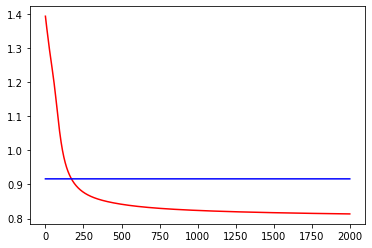

In [48]:
def fit(x,y,model,opt,loss_fn,epochs=2000,log=False):
    loss_err = []
    acc_err = [] 
    for epoch in range(epochs):
        loss =loss_fn(model(x),y.long())
        loss_err.append(loss.item())
        acc_err.append(accuracy_fn(y_hat,y_train))
        
        loss.backward()
        opt.step()
        opt.zero_grad()

    if log: 
        plt.plot(loss_err,'r-')
        plt.plot(acc_err,'b-')
        print(f"Loss before training : {loss_err[0]}")
        print(f"Loss after training : {loss_err[-1]}")

    

model = NNLinearNetwork_v2()
loss_fn = Fn.cross_entropy
opt = optim.SGD(model.parameters(),lr=1)

fit(x=X_train,y=y_train,model=model,opt=opt,loss_fn=loss_fn,log=True)

	

## Running in GPU

In [49]:
import torch.nn as nn
from torch import optim
import time


In [59]:
class NNLinearNetwork_v3(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(0)      
        self.net = nn.Sequential(
            nn.Linear(2,1024*4),
            nn.Sigmoid(),
            nn.Linear(1024*4,4),
            nn.Softmax(dim=1)
        )
        
    def forward(self,X):
        return self.net(X)


In [56]:
def fit(x,y,model,opt,loss_fn,epochs=2000,log=False):
    loss_err = []
    acc_err = [] 
    for epoch in range(epochs):
        loss =loss_fn(model(x),y.long())
        loss_err.append(loss.item())
        
        loss.backward()
        opt.step()
        opt.zero_grad()

    if log: 
        print(f"Loss before training : {loss_err[0]}")
        print(f"Loss after training : {loss_err[-1]}")	

In [60]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device("cpu") #cuda #cpu
print(device)

X_train = X_train.to(device)
y_train = y_train.to(device)
model = NNLinearNetwork_v3()
model.to(device)

cpu


NNLinearNetwork_v3(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=4096, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=4096, out_features=4, bias=True)
    (3): Softmax(dim=1)
  )
)

In [61]:
loss_fn = Fn.cross_entropy
opt = optim.SGD(model.parameters(),lr=1)
tic = time.time()
fit(x=X_train,y=y_train,model=model,opt=opt,loss_fn=loss_fn)
toc = time.time()
print(f"Time taken {toc-tic}")

Time taken 86.75285720825195


In [62]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = torch.device("cpu") #cuda #cpu
print(device)

X_train = X_train.to(device)
y_train = y_train.to(device)
model = NNLinearNetwork_v3()
model.to(device)
tic = time.time()
fit(x=X_train,y=y_train,model=model,opt=opt,loss_fn=loss_fn)
toc = time.time()
print(f"Time taken {toc-tic}")

cuda
Time taken 2.0758891105651855
